# 1. Introduction


I recently read [this article](https://towardsdatascience.com/why-training-set-should-always-be-smaller-than-test-set-61f087ed203c) on medium, which proposes using small training sets and large test sets to improve the robustness of test error. The claim was so counter-conventional that I had to look into it myself!

The article played with a toy problem, using 4-million rows of idealized 4-feature linear regression data to show that test error was more stable with a larger test set. This made intuitive sense to me, because the model should have been able to learn the regression almost perfectly, making the resultant error dependent on how large the $\epsilon$ factors of the test set happened to be. These would be more stable in the larger test set and therefore so would the error. However, I wondered how well this would translate to hold-out data. The resultant error metric might be more stable, but would it be more representative of actual results?

The article also showed that the resultant average error was higher when using a small training set. This did not make sense to me, because models should only get better when given more representative data. I was curious if this was somehow an artifact of an extremely well-fit model, which would not happen often in nature. Would the result hold with a smaller training set?

To answer these two questions, I set up my own version of the experiment with smaller overall data sets and an additional hold-out set

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [4]:
def estimate_error_random(X_test,y_test, model):
    n_iter = 100
    errors = []

    indices = list(range(X_test.shape[0]))
    for i in range(n_iter):
        new_indices = np.random.choice(indices,len(indices),replace=True)

        new_X_test = X_test[new_indices]
        new_y_test = y_test[new_indices]

        new_y_pred = model.predict(new_X_test)

        new_error = np.sqrt(mean_squared_error(new_y_test,new_y_pred))

        errors.append(new_error)

    return np.mean(errors),np.std(errors)

In [12]:
def run_experiment(n):
    X = np.random.normal(size=40*n + 100).reshape(10*n + 25,4)
    y = []

    for record in X:
        y.append(np.sum(record) + np.random.normal())
    
    y = np.array(y)
    
    X_holdout = X[-25:]
    y_holdout = y[-25:]
    X = X[:-25]
    y = y[:-25]
    
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2)
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.8)

    model_1 = LinearRegression()
    model_2 = LinearRegression()
    model_full = LinearRegression()

    model_1.fit(X_train_1,y_train_1)
    model_2.fit(X_train_2,y_train_2)
    model_full.fit(X,y)
    
    model_1_res = estimate_error_random(X_test_1,y_test_1, model_1)
    model_2_res = estimate_error_random(X_test_2,y_test_2, model_2)
    
    y_holdout_pred = model_full.predict(X_holdout)
    model_full_error = np.sqrt(mean_squared_error(y_holdout,y_holdout_pred))
        
    return model_1_res, model_2_res, model_full_error

def run_many_experiments(n, t):
    res1_mean = []
    res1_error = []
    res2_mean = []
    res2_error = []
    full_error = []
    
    for i in range(t):
        res = run_experiment(n)
        res1_mean = res1_mean + [res[0][0]]
        res1_error = res1_error + [res[0][1]]
        res2_mean = res2_mean + [res[1][0]]
        res2_error = res2_error + [res[1][1]]
        full_error = full_error + [res[2]]

    return np.mean(res1_mean),np.mean(res1_error),np.mean(res2_mean),np.mean(res2_error), np.mean(full_error)



# 2. Matching holdout performance

In [13]:
res = [run_many_experiments(n,50) for n in range(1,30)]
y_1_mean= [r[0] for r in res]
y_1_error = [r[1] for r in res]

y_2_mean= [r[2] for r in res]
y_2_error = [r[3] for r in res]

full_error = [r[4] for r in res]

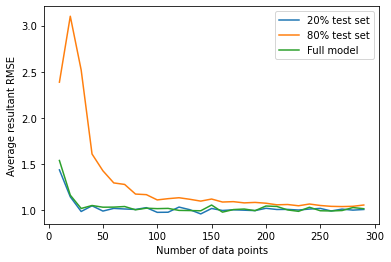

In [14]:
plt.plot(list(range(10,300,10)), y_1_mean, label = '20% test set')
plt.plot(list(range(10,300,10)), y_2_mean, label = '80% test set')
plt.plot(list(range(10,300,10)), full_error, label = 'Full model')

plt.xlabel('Number of data points')
plt.ylabel('Average resultant RMSE')
plt.legend()
plt.show()

The test error from the model based on the small test set and large training set is consistently more in line with holdout error. Intuitively, this makes sense- the 100% model only uses 25% more data than the version created with an 80% train set, but it uses 400% more data than the version created with a 20% train set.

# 3. Robustness of error

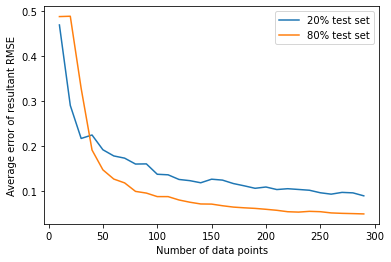

In [15]:
plt.plot(list(range(10,300,10)), y_1_error, label = '20% test set')
plt.plot(list(range(10,300,10)), y_2_error, label = '80% test set')
plt.xlabel('Number of data points')
plt.ylabel('Average error of resultant RMSE')
plt.legend()
plt.show()

In terms of test error stability, the larger test set model does eventually overcome the smaller test set model. This is probably because of the phenomena mentioned before, which is that with highly-specified models the resultant error comes down to $\epsilon$ factors, which are more stable with the larger test set. 

On the other hand, it seems like with less data, the large train set version actually has more stable error. I believe this is because when the model is not highly-specified, it can vary wildly depending on how well the train data happens to represent the system overall. When the small train set happens to be slightly out of whack, the error might be extreme. That is less likely to happen with the larger train set